###Import Module

In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

###Calculate Entropy

In [ ]:
def entropy(freq):
    freq_0 = freq[np.array(freq).nonzero()[0]]
    prob_0 = freq_0/float(freq_0.sum())
    return -np.sum(prob_0*np.log2(prob_0))

###node of tree
#####each node are instance of tree class

In [ ]:
class TreeNode(object):
    def __init__(self, ids =[], children = [], entropy = 0, depth = 0):
        self.ids = ids           
        self.entropy = entropy  
        self.depth = depth      
        self.split_attribute = None 
        self.children = children 
        self.order = None     
        self.label = None  

    def __repr__(self):
        if self.split_attribute!=None :
          return self.split_attribute   
        else: 
          return 'leaf'
    
    def set_properties(self, split_attribute, order):
        self.split_attribute = split_attribute
        self.order = order

    def set_label(self, label):
        self.label = label

###ID3
##### In this class we calculate entropy and choose best attribute for root. we can fit data and evaluate tree and proun it

In [ ]:
class DecisionTreeID3(object):
    def __init__(self, max_depth= 10):
        self.root = None 
        self.max_depth = max_depth
        self.num_train = 0 
        self.nodes=[] 
    
    def fit(self, data, target, x_val, y_val):
        #print('step 1')
        # print('type', type(data), end='\n')
        # print('head',data.head())
        # print('count',data.count())
        # print('len data',len(data))
        self.num_train = data.count()[1]  
        # print('step 2')
        self.data = data              
        # print('step 3')
        self.attributes = list(data)  
        # print('step 4')
        self.target = target         
        # print('step 5')
        self.labels = target.unique()
        ids = range(self.num_train)
        # print('step6')
        self.root = TreeNode(ids = ids, entropy = self._entropy(ids), depth = 0)  
        queue = [self.root]
        # print(queue)
        # print('step7')

        while queue: 
            node = queue.pop()

            if node.depth < self.max_depth:
                node.children = self._split(node)
                if not node.children: 
                    self._set_label(node)
                queue += node.children
                self.nodes += node.children
            else:
                self._set_label(node)
        # print('step8')

    def predict(self, new_data):
        # print('predict 0')
        # print(new_data.head())
        num_points = new_data.count()[0]
        # print('predict 1')
        labels = [None]*num_points
        for n in range(num_points):
            x = new_data.iloc[n, :] 
            node = self.root
            while node.children: 
                if x[node.split_attribute] in node.order:
                    node = node.children[node.order.index(x[node.split_attribute])]
                else:           
                    node.label=self._set_label(node)
                    break
            labels[n] = node.label  
        return labels
        # print('step13')

    def evaluation(self,x_test,y_test,show_acc=False):
      # print('eval 0')
      z=self.predict(x_test)
      # print('eval 1')
      count=0
      for i in range(len(y_test)):
          if y_test[i]==z[i]:
              count+=1
      # print('eval 2')
      if show_acc:
          print((count/len(x_test))*100) 
      self.acc=(count/len(x_test))*100
      # print('eval 3')
      return (count/len(x_test))*100

      self.acc=self.evaluation(x_val,y_val,True)
      # print('step9')
      
        
    def _entropy(self, ids):
        if len(ids) == 0: return 0
        ids=list(ids)
        freq = np.array(self.target[ids].value_counts())
        return entropy(freq)
        # print('step10')

    def _set_label(self, node):
        target_ids =list(node.ids)
        node.set_label(self.target[target_ids].mode()[0])
        # print('step11')

    
    def _split(self, node):
        ids = node.ids 
        best_gain = 0
        best_splits = []
        best_attribute = None
        order = None
        sub_data = self.data.iloc[ids, :]
        for i, att in enumerate(self.attributes):
            values = self.data.iloc[ids, i].unique().tolist()
            if len(values) == 1: continue # entropy = 0
            splits = []
            for val in values: 
                sub_ids = sub_data.index[sub_data[att] == val].tolist()
                splits.append([sub_id for sub_id in sub_ids])
                temp= 0
            for split in splits:
                temp += len(split)*self._entropy(split)/len(ids)
            gain = node.entropy - temp 
            if gain > best_gain:
                best_gain = gain 
                best_splits = splits
                best_attribute = att
                order = values
        node.set_properties(best_attribute, order)
        child_nodes = [TreeNode(ids = split,
                     entropy = self._entropy(split), depth = node.depth + 1) for split in best_splits]
        return child_nodes
        # print('step12')


    
    def _eval(self,x_test,y_test,show_acc=False):
        z=self.predict(x_test)
        count=0
        for i in range(len(y_test)):
            if y_test[i]==z[i]:
                count+=1
        if show_acc:
            print((count/len(x_test))*100) 
        return count/len(x_test)*100  
        # print('step14')  
    
    
    def pruning(self,x2,y2,x_tr,y_tr,x_te,y_te): 
        max_depth=0
        for n in self.nodes:
            if n.depth>max_depth:
                max_depth=n.depth
        prun_list=[]
        for n in self.nodes:
            if n.children:
                prun_list.append(n)
        prun_list1=[]
        for dep in range(1,max_depth):
            for n in prun_list:
                if n.depth==dep: prun_list1.append(n)   
        before_pr=len(prun_list1)
        acc=100
        last_acc=self.acc
        nodes=[]
        val_acc=[]
        acc_matrix=[]
        print("before while")
        while acc +.2 >= last_acc: 
            pr_node=prun_list1.pop()
            if pr_node.children:
                last_node=pr_node.children
                pr_node.children=[]
                self._set_label(pr_node)
                last_acc=self.acc
                acc=self.evaluation(x2,y2,False)
                before_pr-=1
                nodes.append(before_pr)
                print('before_pr: ',before_pr)
                val_acc.append(self._eval(x2,y2,True))
                print('***','    ')
                print('****','    ')
                print('there we are!')
        pr_node.children=last_node        
        self.acc=self.evaluation(x2,y2)
        print('there we are append!')
        #acc_matrix.append(self.acc)
        print('we appended')

        
        return nodes,val_acc


###Loading data and label encoding

In [ ]:
def load_data(add):
    data=pd.read_csv(add, names=list(range(9)))
    data=pd.DataFrame(data)
    data=data.replace({'<=50K':0})
    data=data.replace({'>50K':1})
    return data

###Separate percentage from data and shuffle it

In [ ]:
def pre_train(train_data,percentage):
    idx=range(len(train_data))
    idx=list(idx)
    random.shuffle(idx)
    aa=int(percentage*len(train_data)/100)
    idx=idx[:aa]
    x1=train_data.iloc[idx,:]
    x1.index=range(aa)
    x = x1.iloc[:, 1:]
    x.columns = list(range(8))
    y = x1.iloc[:, 0] 
    return x,y

In [ ]:
def train_val_split(data,percentage):
    idx=range(len(data))
    idx=list(idx)
    random.shuffle(idx)
    aa=int(percentage*len(data)/100)
    idx1=idx[:aa]
    idx2=idx[aa:]
    x_tr=data.iloc[idx1,:]
    x_val=data.iloc[idx2,:]
    x_tr.index=range(aa)
    x_val.index=range(len(data)-aa)
    x_tr_ = x_tr.iloc[:, 1:]
    x_tr_.columns = list(range(8))
    y_tr_ = x_tr.iloc[:, 0] 
    x_val_ = x_val.iloc[:, 1:]
    x_val_.columns = list(range(8))
    y_val_= x_val.iloc[:, 0] 
    
    return x_tr_,y_tr_,x_val_,y_val_  

###Loading dataset and make train and validation dataset

In [ ]:
data=load_data('/content/drive/MyDrive/Machine Learning/adult.train.10k.discrete')
# print(type(data))
# print(data.head())
x1,y1,x2,y2=train_val_split(data,75)
# print(type(x1), type(y1))
# print(x1.head())
# print('here!')
x1,y1=pre_train(data,100)
# print(type(x1), type(y1))
# print(x1.head())
# print('here!')
test_data=load_data('/content/drive/MyDrive/Machine Learning/adult.test.10k.discrete')
# print('here!')
print(test_data.head())
# print('here!')
#print(test_data.index)
x2,y2,x_test,y_test=train_val_split(test_data,25)
x_test = test_data.iloc[:, 1:]
x_test.columns = list(range(8))
y_test= test_data.iloc[:, 0] 


   0           1              2                    3                   4  \
0  0     Private           11th        Never-married   Machine-op-inspct   
1  0     Private        HS-grad   Married-civ-spouse     Farming-fishing   
2  1   Local-gov     Assoc-acdm   Married-civ-spouse     Protective-serv   
3  1     Private   Some-college   Married-civ-spouse   Machine-op-inspct   
4  0     Private           10th        Never-married       Other-service   

                5       6      7               8  
0       Own-child   Black   Male   United-States  
1         Husband   White   Male   United-States  
2         Husband   White   Male   United-States  
3         Husband   Black   Male   United-States  
4   Not-in-family   White   Male   United-States  


###Train algorithm

In [ ]:
tree = DecisionTreeID3(max_depth = 8)
tree.fit(x1,y1,x2,y2)

###Evaluate Algorithm

In [ ]:
tree.evaluation(x_test,y_test)

77.06

In [ ]:
tree.pruning(x2, y2, x1, y1, x_test, y_test)

before while
before_pr:  705
76.88000000000001
***     
****     
there we are!
before_pr:  704
76.88000000000001
***     
****     
there we are!
before_pr:  703
76.88000000000001
***     
****     
there we are!
before_pr:  702
76.88000000000001
***     
****     
there we are!
before_pr:  701
76.88000000000001
***     
****     
there we are!
before_pr:  700
76.88000000000001
***     
****     
there we are!
before_pr:  699
76.88000000000001
***     
****     
there we are!
before_pr:  698
76.88000000000001
***     
****     
there we are!
before_pr:  697
76.88000000000001
***     
****     
there we are!
before_pr:  696
76.88000000000001
***     
****     
there we are!
before_pr:  695
76.88000000000001
***     
****     
there we are!
before_pr:  694
76.88000000000001
***     
****     
there we are!
before_pr:  693
76.88000000000001
***     
****     
there we are!
before_pr:  692
76.88000000000001
***     
****     
there we are!
before_pr:  691
76.88000000000001
***     
****  

([705,
  704,
  703,
  702,
  701,
  700,
  699,
  698,
  697,
  696,
  695,
  694,
  693,
  692,
  691,
  690,
  689,
  688,
  687,
  686,
  685,
  684,
  683,
  682,
  681,
  680,
  679,
  678,
  677,
  676,
  675,
  674,
  673,
  672,
  671,
  670,
  669,
  668,
  667,
  666,
  665,
  664,
  663,
  662,
  661,
  660,
  659,
  658,
  657,
  656,
  655,
  654,
  653,
  652,
  651,
  650,
  649,
  648,
  647,
  646,
  645,
  644,
  643,
  642,
  641,
  640,
  639,
  638,
  637,
  636,
  635,
  634,
  633,
  632,
  631,
  630,
  629,
  628,
  627,
  626,
  625,
  624,
  623,
  622,
  621,
  620,
  619,
  618,
  617,
  616,
  615,
  614,
  613,
  612,
  611,
  610,
  609,
  608,
  607,
  606,
  605,
  604,
  603,
  602,
  601,
  600,
  599,
  598,
  597,
  596,
  595,
  594,
  593,
  592,
  591,
  590,
  589,
  588,
  587,
  586,
  585,
  584,
  583,
  582,
  581,
  580,
  579,
  578,
  577,
  576,
  575,
  574,
  573,
  572,
  571,
  570,
  569,
  568,
  567,
  566,
  565,
  564,
  563,

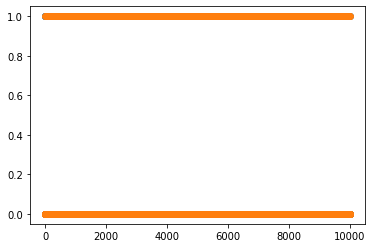

In [ ]:
plt.plot(y_test, 'o')
plt.plot(y1, 'o')

#  Eval

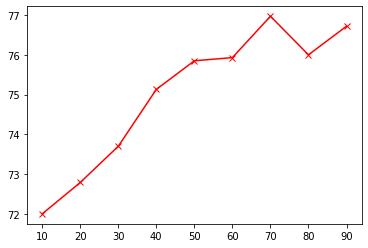

In [ ]:
data=load_data('/content/drive/MyDrive/Machine Learning/adult.train.10k.discrete')
train_percentages = [10 * i for i in range(1, 10)]
accs = []
for percentage in train_percentages: 
  x1,y1,x2,y2=train_val_split(data,percentage)
  #x1,y1=pre_train(data,100)
  test_data=load_data('/content/drive/MyDrive/Machine Learning/adult.test.10k.discrete')
  x2,y2,x_test,y_test=train_val_split(test_data,25)
  x_test = test_data.iloc[:, 1:]
  x_test.columns = list(range(8))
  y_test= test_data.iloc[:, 0] 
  tree = DecisionTreeID3(max_depth = 8)
  tree.fit(x1,y1,x2,y2)
  acc = tree.evaluation(x_test,y_test)
  accs.append(acc)

plt.figure()
plt.plot(train_percentages, accs, 'rx-')
plt.show()